In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import scipy.stats as stats

In [244]:
df = pd.read_csv('stock fundamental data.csv')
df.head()
len(df)

50560

# Preprocessing data


In [245]:
# check for any null values in market value 
df.isnull().sum()

gvkey          0
tic            0
fyear         51
indfmt         0
consol         0
popsrc         0
datafmt        0
curcd         51
act        21788
ap         10863
at          6722
ceq         6843
che        13777
cogs       13868
dlc         7086
dlcch      31465
dltt        6884
dp          9347
dvc         7149
ib          6821
intan       7427
invt       12160
ivao       15275
lct        21720
lt          6792
nopio      17628
ppent       8714
rect       14032
sale       13865
spi         7300
txp        15200
txt         6826
xad        35615
xido        6821
xint       12512
xrd        31021
xsga       19673
costat         0
mkvalt     14697
dtype: int64

In [246]:
#create column 'future mkvalt' that holds the market value of the next year
condition1 = df['tic'].shift(-1) == df['tic']
condition2 = df['fyear'].shift(-1) == df['fyear'] + 1
df['future_mkvalt'] = np.where(condition1 & condition2, df['mkvalt'].shift(-1), np.nan)

#drop nulls
df = df.dropna(subset=['mkvalt', 'future_mkvalt'], how='all')

#percent change is the percent change in market value from one year to the next
df['percent_change'] = (df['future_mkvalt']-df['mkvalt'])/df['mkvalt']

#if percent change is greater than 20%, classify as undervalued
df['undervalued'] = (df['percent_change'] > 0.10)

In [247]:
#fill null expenses with 0
df['xrd'] = df['xrd'].fillna(0)
df['xad'] = df['xad'].fillna(0)
df['xsga'] = df['xsga'].fillna(0)
df['xint'] = df['xint'].fillna(0)
df['dlcch'] = df['dlcch'].fillna(0)



#combine all expenses columns into one column
expenses_list = ['xrd', 'xad', 'xsga', 'xint', 'nopio', 'cogs']
df['expenses'] = df[expenses_list].sum(axis=1)

df = df.drop(columns=expenses_list)

#delete duplicate rows due to formatting
condition = df['indfmt'] != "FS"
df = df[condition]

#drop unneccessary columns
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'gvkey', 'costat'])




In [248]:
df.isnull().sum()

tic                  0
fyear                0
act               7179
ap                 277
at                  98
ceq                154
che                 99
dlc                102
dlcch                0
dltt               231
dp                1619
dvc                251
ib                 158
intan              538
invt               459
ivao              1468
lct               7119
lt                 148
ppent             1258
rect               309
sale               157
spi                525
txp               4285
txt                163
xido               159
mkvalt            1742
future_mkvalt     4277
percent_change    6019
undervalued          0
expenses             0
dtype: int64

In [249]:
#remove rows with null values
condition = df.isnull().sum(axis=1) < 1
df = df[condition]

In [250]:
df.head(20)

,tic,fyear,act,ap,at,ceq,che,dlc,dlcch,dltt,...,sale,spi,txp,txt,xido,mkvalt,future_mkvalt,percent_change,undervalued,expenses
0,AIR,2009.0,863.429,114.906,1501.042,746.906,79.370,100.833,-4.996,336.191,...,1352.151,-4.302,3.263,20.986,0.000,777.8348,1049.8206,0.349670,True,1243.600
1,AIR,2010.0,913.985,185.096,1703.727,835.845,57.433,114.075,54.991,329.802,...,1775.782,-1.536,0.000,35.364,-3.313,1049.8206,485.2897,-0.537740,False,1613.484
2,AIR,2011.0,1063.272,201.405,2195.653,864.649,67.720,122.865,0.000,669.489,...,2074.498,-13.864,0.000,25.480,0.000,485.2897,790.0029,0.627900,True,1891.119
3,AIR,2012.0,1033.700,149.300,2136.900,918.600,75.300,86.400,0.000,622.200,...,2167.100,-21.100,0.000,26.700,0.000,790.0029,961.3080,0.216841,True,1970.300
4,AIR,2013.0,1116.900,171.100,2199.500,999.500,89.200,69.700,10.000,564.300,...,2035.000,0.000,0.000,32.100,0.000,961.3080,1046.3954,0.088512,False,1824.100
5,AIR,2014.0,954.100,142.300,1515.000,845.100,54.700,69.000,-80.000,85.000,...,1594.300,-48.400,0.000,-28.500,64.700,1046.3954,842.5112,-0.194844,False,1537.300
6,AIR,2015.0,873.100,163.400,1442.100,865.800,31.200,12.000,60.000,136.100,...,1662.600,-0.400,1.100,18.800,7.200,842.5112,1200.3288,0.424704,True,1531.800
7,AIR,2016.0,888.500,177.400,1504.100,914.200,10.300,2.000,21.000,155.300,...,1767.600,2.600,12.300,24.100,6.300,1200.3288,1551.4580,0.292528,True,1624.700
8,AIR,2017.0,942.700,170.000,1524.700,936.300,41.600,0.000,-1.000,177.200,...,1748.300,0.000,0.000,3.500,-58.100,1551.4580,1046.7709,-0.325299,False,1628.900
11,AAL,2011.0,6757.000,1007.000,23848.000,-7111.000,4739.000,1518.000,0.000,6702.000,...,24022.000,-886.000,0.000,0.000,0.000,117.3438,266.5571,1.271591,True,24332.000


In [251]:
# check for any null values
df.isnull().sum()

tic               0
fyear             0
act               0
ap                0
at                0
ceq               0
che               0
dlc               0
dlcch             0
dltt              0
dp                0
dvc               0
ib                0
intan             0
invt              0
ivao              0
lct               0
lt                0
ppent             0
rect              0
sale              0
spi               0
txp               0
txt               0
xido              0
mkvalt            0
future_mkvalt     0
percent_change    0
undervalued       0
expenses          0
dtype: int64

In [252]:
# new length of df after processing
len(df)

18538

# remove outliers

In [170]:
original_columns = df.columns

In [172]:
target_cols = list(df.drop(columns = ["fyear", "undervalued","tic"]).columns)

z_score_cols = []

# Loop through our target columns
for col in target_cols:
    # Make the new column name the same as the original but with 'z_score' added to it
    new_col_name = col + "_zscore"
    
    # Set the new column equal to the score
    df[new_col_name] = stats.zscore( df[col] )
    
    # Set the z-score to its absolute value of the for easier filtering
    df[new_col_name] = abs( df[new_col_name] )
    
    # Append the new column name our our z_score_cols list for easier access for later.
    z_score_cols.append(new_col_name)


condition = df[z_score_cols] < 3
print(df.shape)

# # Say TRUE only if all of the rows are True, else return False
condition = condition.all(axis=1)

print('Before removal of outliers', df.shape)

df = df[condition]

print('After removal of outliers', df.shape)

(18538, 57)
Before removal of outliers (18538, 57)
After removal of outliers (17425, 57)


In [173]:
#keep original columns only
df = df[original_columns]
len(df)

17425

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

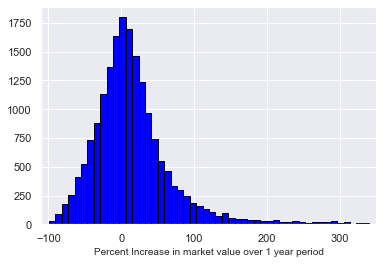

In [253]:
binwidth=0.1
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
    
# Draw the plot
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
plt.xlim(-110, 350)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

In [254]:
#remove outliers
condition1 = df['percent_change'] < 1
df = df[condition1]

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

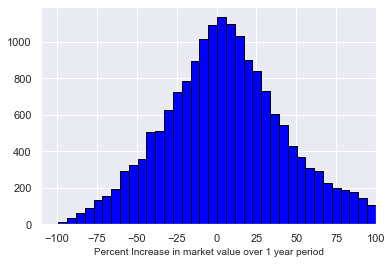

In [255]:
#replot
binwidth=5
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
#Title and labels
plt.xlim(-110, 100)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

# visualize the data

array([[<AxesSubplot: title={'center': 'fyear'}>,
        <AxesSubplot: title={'center': 'act'}>,
        <AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'at'}>,
        <AxesSubplot: title={'center': 'ceq'}>],
       [<AxesSubplot: title={'center': 'che'}>,
        <AxesSubplot: title={'center': 'dlc'}>,
        <AxesSubplot: title={'center': 'dlcch'}>,
        <AxesSubplot: title={'center': 'dltt'}>,
        <AxesSubplot: title={'center': 'dp'}>],
       [<AxesSubplot: title={'center': 'dvc'}>,
        <AxesSubplot: title={'center': 'ib'}>,
        <AxesSubplot: title={'center': 'intan'}>,
        <AxesSubplot: title={'center': 'invt'}>,
        <AxesSubplot: title={'center': 'ivao'}>],
       [<AxesSubplot: title={'center': 'lct'}>,
        <AxesSubplot: title={'center': 'lt'}>,
        <AxesSubplot: title={'center': 'ppent'}>,
        <AxesSubplot: title={'center': 'rect'}>,
        <AxesSubplot: title={'center': 'sale'}>],
       [<AxesSubplot: title=

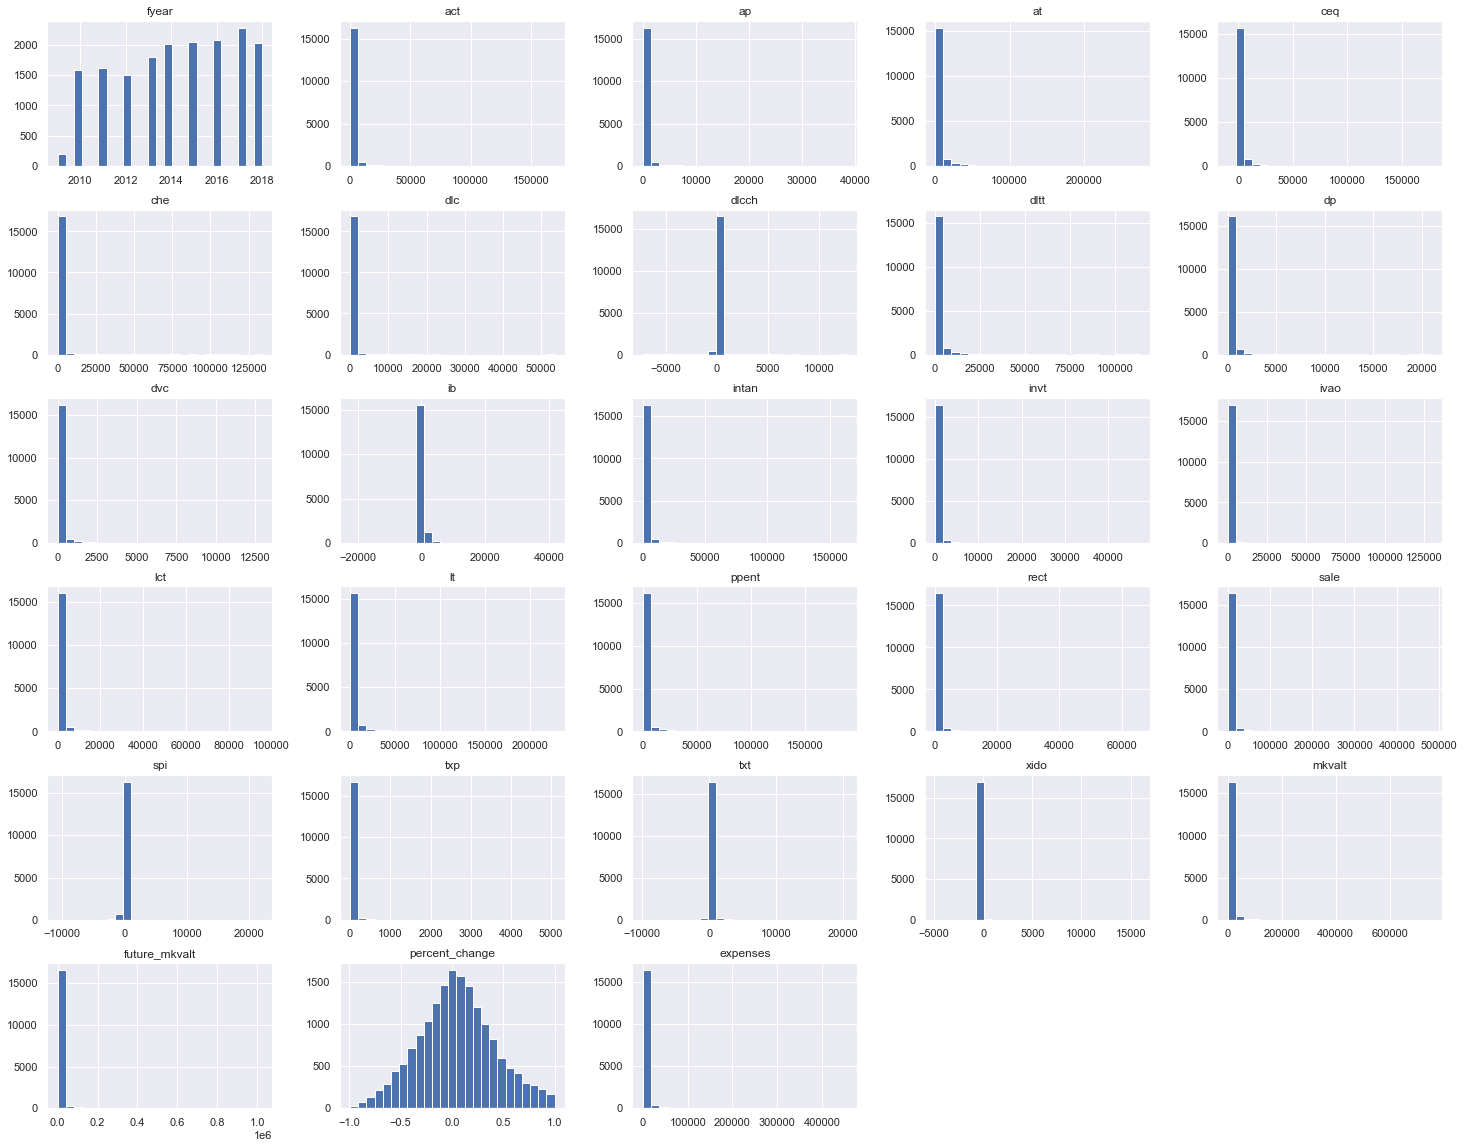

In [205]:
df.hist(bins = 25 ,figsize = (25,20))

# Feature engineering

In [256]:
#feature selection 
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

# selected features and predict value
Features = list(df.drop(columns=['tic', 'fyear', 'undervalued','percent_change']).columns)
X = df[Features]
y = df['future_mkvalt']

#find best features
fs = SelectKBest(score_func=f_regression)

X_selected = fs.fit_transform(X,y)

In [257]:
# best features according to pearson test 
selected_features = fs.get_feature_names_out()
X = df[selected_features]

In [258]:
#print values of the features
fs.scores_

array([1.37983202e+01, 2.47752084e+00, 9.25971057e+00, 3.85450252e+00,
       1.22446702e+01, 2.18278842e+00, 1.22657359e+00, 1.07232518e+01,
       2.26788849e+00, 6.35306966e+00, 6.86617807e+00, 8.82176327e+00,
       3.23074298e+00, 1.68063219e+00, 1.03395956e+01, 1.16114517e+01,
       8.48205250e-01, 5.73845376e+00, 6.60528641e+00, 4.20827715e+00,
       2.82782659e-02, 2.07946760e+00, 1.16013066e+00, 1.16409423e+01,
       7.84827997e+01, 6.39848525e+00])

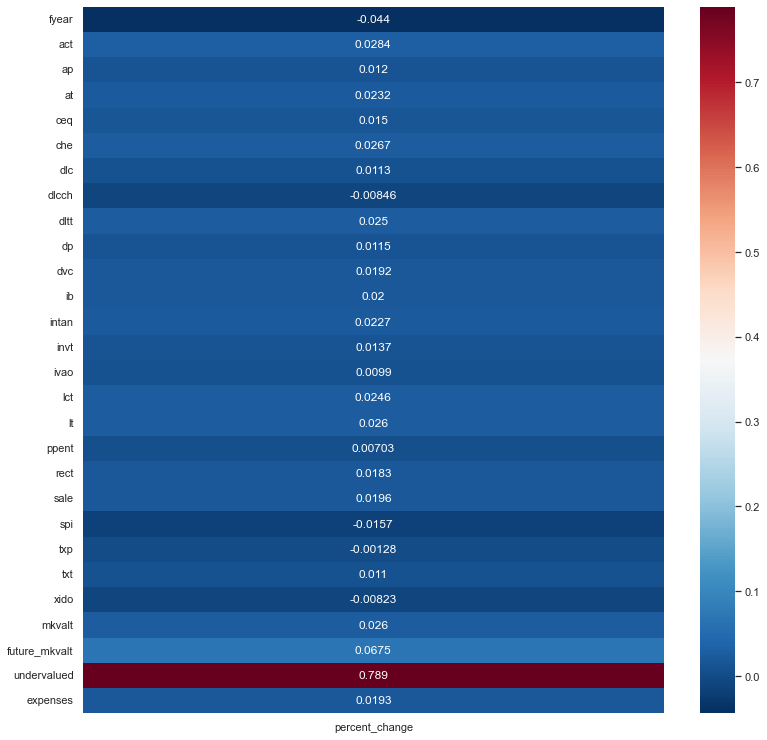

In [259]:
#create heatmap showing which values correlate most with undervalued helps select features

def create_corr_matrix(column_name):
    corr_mat = df.corr()

    corr_targ = corr_mat[[column_name]].drop(labels=[column_name])
    fig, ax = plt.subplots(figsize = (13,13))
    sns.heatmap(corr_targ, annot= True, fmt='.3',cmap='RdBu_r')
    plt.show()
    

create_corr_matrix("percent_change")

# Model building and evaluation

In [281]:
# Create training and test set from data 

# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=45)

# split training and testing data like this so no data leakage
X_train = X.iloc[3800:]
X_test = X.iloc[:3800]
y_train = y.iloc[3800:]
y_test = y.iloc[:3800]

In [282]:
# build pipline which evaluates models 
def build_and_eval_regression_model(model,X,y):
    print("running model report",model)
    
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    y_test = y.iloc[:3800]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    r_squared = metrics.r2_score(y_test,y_pred)
    print("R-squared score:",r_squared)
    
    mea = metrics.mean_absolute_error(y_test,y_pred)
    print("\nMean Absolute Error:",mea)
    
    mse = metrics.mean_squared_error(y_test,y_pred)
    
    print("\nMean squared Error:",mse)

def build_and_eval_classification_model(model,X,y):
    print("running model report",model)
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    y_test = y.iloc[:3800]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test,y_pred)
    print("\nAccuracy Score: %f" % accuracy)

    precision = precision_score(y_test,y_pred)
    print("Precision Score: %f" % precision)

    recall = recall_score(y_test,y_pred)
    print("Recall Score: %f" % recall)

    f1 = f1_score(y_test,y_pred)
    print('F1 Score: %f' % f1)

    # Calculate predicted probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Keep only the proba for True
    y_pred_proba = y_pred_proba[:,1]

    # Compute auc score
    auc = roc_auc_score(y_true = y_test, y_score = y_pred_proba )
    print('AUC Score: %f' % auc)

In [283]:
# choose model and hyperparameters then run a grids search to find best paramaters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DT_model = DecisionTreeRegressor()



params = {'criterion': ['gini', 'entropy'],
        'max_depth': [3,5,7],
        'min_samples_leaf': [5,10, 25],
        'min_samples_split': [8, 10, 12],
        'max_features' : [2,6,8,None]
          }

gs = GridSearchCV(estimator=DT_model,
                      param_grid=params,cv=3,
                     refit=True)

gs.fit(X_train_scaled, y_train)
gs.best_params_

ValueError: 
All the 648 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1342, in fit
    super().fit(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 394, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_, n_samples)
KeyError: 'gini'

--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1342, in fit
    super().fit(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 394, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_, n_samples)
KeyError: 'entropy'


In [272]:
# train model using best parameters then test scores
rf = RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                           min_samples_split=10, n_estimators=100)
build_and_eval_regression_model(rf,X,y)

running model report RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)
R-squared score: 0.5533401674954925

Mean Absolute Error: 0.13904465657050488

Mean squared Error: 0.04112704899650013


In [214]:
# linear regression
lr = LinearRegression()
build_and_eval_regression_model(lr,X,y)

running model report LinearRegression()
R-squared score: -0.1300158536399787

Mean Absolute Error: 0.22252625645512233

Mean squared Error: 0.10404834730466687


In [238]:
# Knn Regressor 
k = 15
knnreg = KNeighborsRegressor(n_neighbors= k )
build_and_eval_regression_model(knnreg,X,y)

running model report KNeighborsRegressor(n_neighbors=15)
R-squared score: 0.15110753941891242

Mean Absolute Error: 0.21233289612176476

Mean squared Error: 0.07816337910511716


In [264]:
#decision tree regressor
dt = gs.best_estimator_
build_and_eval_regression_model(dt,X,y)

running model report RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)
R-squared score: 0.5570780678976324

Mean Absolute Error: 0.13772862005877454

Mean squared Error: 0.04078287474621921


In [265]:
#convert predicted percent changes into undervalued or overvalued 
y_test = y.iloc[:3800]

def build_model(model,X,y):
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    return y_pred
    

def undervalued(prediction):
    arr = np.where(prediction > .10,True,False)
    return arr

In [266]:
# Evaluate and print model scores using accuracy, precision, recall, f1 scores, and auc scores. 
def test_regression_conversion(model,undervalued_y_test,undervalued_y_pred):
    
    print("running test for model",model)
    accuracy = accuracy_score(undervalued_y_test,undervalued_y_pred)
    print("\nAccuracy Score: %f" % accuracy)

    precision = precision_score(undervalued_y_test,undervalued_y_pred)
    print("Precision Score: %f" % precision)

    recall = recall_score(undervalued_y_test,undervalued_y_pred)
    print("Recall Score: %f" % recall)

    f1 = f1_score(undervalued_y_test,undervalued_y_pred)
    print('F1 Score: %f' % f1)

In [267]:
# y test set turned to true false for testing
undervalued_y_test = undervalued(y_test)

In [268]:
#random forest test
y_pred_rf = build_model(rf,X,y)
undervalued_y_pred_rf = undervalued(y_pred_rf)

test_regression_conversion(rf,undervalued_y_test,undervalued_y_pred_rf)

running test for model RandomForestRegressor(max_depth=7, max_features=8, min_samples_leaf=10,
                      min_samples_split=12, n_estimators=800)

Accuracy Score: 0.741053
Precision Score: 0.643359
Recall Score: 0.958673
F1 Score: 0.769986


In [269]:
# linear regression test
y_pred_lr = build_model(lr,X,y)
undervalued_y_pred_lr = undervalued(y_pred_lr)

test_regression_conversion(lr,undervalued_y_test,undervalued_y_pred_lr)

running test for model LinearRegression()

Accuracy Score: 0.645000
Precision Score: 0.865347
Recall Score: 0.254366
F1 Score: 0.393162


In [270]:
# K nearest test
y_pred_kn = build_model(knnreg,X,y)
undervalued_y_pred_kn = undervalued(y_pred_kn)

test_regression_conversion(knnreg,undervalued_y_test,undervalued_y_pred_kn)

running test for model KNeighborsRegressor(n_neighbors=15)

Accuracy Score: 0.641053
Precision Score: 0.620737
Recall Score: 0.529686
F1 Score: 0.571608


In [271]:
# decision Tree test
y_pred_dt = build_model(rf,X,y)
undervalued_y_pred_rf = undervalued(y_pred_dt)

test_regression_conversion(dt,undervalued_y_test,undervalued_y_pred_rf)

running test for model RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)

Accuracy Score: 0.739211
Precision Score: 0.641937
Recall Score: 0.956927
F1 Score: 0.768404


In [289]:
# find most important features
# feature_imp = pd.DataFrame.from_dict( {'feature_importance': rf_model.feature_importances_,
#                                        'feature':selected_features}).sort_values('feature_importance', ascending=False)
# feature_imp

In [290]:
# find the total return if you would invest in certain companies 
def find_return(df,model,y_test,undervalued_y_pred):
    undervalued_y_pred = undervalued_y_pred.tolist()
    gains = 0
    investment = 0
    arr = y_test.index
    len(arr)
    for i in range(len(undervalued_y_pred)):
        if(undervalued_y_pred[i]):
            index = arr[i]
            investment = investment + 100
            change = 100  + 100*(df.loc[[index]]['percent_change'].values)
            gains = gains + change
    
    print("return for model",model)
    print('Initial Investment: ' + str(investment))
    print('Total Return: ' + str(gains))
    print('Percent increase: ' + str((gains-investment)/investment))       


In [294]:
# random forest returns 
find_return(df,rf,y_test,undervalued_y_pred_rf)

return for model RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)
Initial Investment: 256100
Total Return: [306326.86949794]
Percent increase: [0.1961221]


In [295]:
# linear regression returns 
find_return(df,lr,y_test,undervalued_y_pred_lr)

return for model LinearRegression()
Initial Investment: 50500
Total Return: [65689.12981451]
Percent increase: [0.30077485]


In [296]:
# k nearest returns 
find_return(df,knnreg,y_test,undervalued_y_pred_kn)

return for model KNeighborsRegressor(n_neighbors=15)
Initial Investment: 146600
Total Return: [175279.33971697]
Percent increase: [0.19562988]


In [ ]:
# decision tree returns 
find_return(df,rf,y_test,undervalued_y_pred_dt)